In [1]:
import pandas as pd
import numpy as np
from os import listdir
from pickle import dump
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from keras.models import Model
from keras.utils import to_categorical
import string, re
from tqdm import tqdm
from keras.applications.xception import Xception, preprocess_input
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from keras.layers import add
from PIL import Image
from keras.utils import plot_model
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu
from nltk.translate.meteor_score import meteor_score
from tensorflow.keras.models import load_model
import pickle
nltk.download('wordnet')

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Processing Text

In [2]:
captions = pd.read_csv('flickr30k/captions.txt', delimiter = "," , index_col = 'comment_number')

In [3]:
captions.head()

,image,caption
comment_number,,
0,1000092795.jpg,Two young guys with shaggy hair look at their ...
1,1000092795.jpg,Two young White males are outside near many b...
2,1000092795.jpg,Two men in green shirts are standing in a yard .
3,1000092795.jpg,A man in a blue shirt standing in a garden .
4,1000092795.jpg,Two friends enjoy time spent together .


In [4]:
captions.shape

(158915, 2)

In [5]:
captions_dict = {}
for index, row in captions.iterrows():
    image_id = row['image'].split('.')[0]
    if image_id  not in captions_dict:
        captions_dict[image_id] = list()
    captions_dict[image_id].append(row['caption'])

In [6]:
captions_dict["1000092795"]

['Two young guys with shaggy hair look at their hands while hanging out in the yard .',
 'Two young  White males are outside near many bushes .',
 'Two men in green shirts are standing in a yard .',
 'A man in a blue shirt standing in a garden .',
 'Two friends enjoy time spent together .']

In [7]:
def clean_captions(captions):
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in tqdm(captions.items()):
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [word.lower() for word in desc]
            desc = [w.translate(table) for w in desc]
            desc = [word for word in desc if len(word)>1]
            desc = [word for word in desc if word.isalpha()]
            desc.insert(0, "startseq")
            desc.insert(len(desc), "endseq")
            desc_list[i] =  ' '.join(desc)

In [8]:
clean_captions(captions_dict)

100%|██████████| 31783/31783 [00:01<00:00, 25734.52it/s]


In [9]:
captions_dict["1000092795"]

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq']

### Train Test Split

In [10]:
test_dict = dict(list(captions_dict.items())[:1000])
train_dict = dict(list(captions_dict.items())[1000:])

### Vocabulary Size

In [11]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(captions):
    all_desc = set()
    for key in captions_dict.keys():
        [all_desc.update(d.split()) for d in captions_dict[key]]
    return all_desc


vocabulary = to_vocabulary(captions_dict)
print('Original Vocabulary Size: {}'.format(len(vocabulary)))

Original Vocabulary Size: 19737


In [12]:
#converting dictionary to clean list of descriptions
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc
#creating tokenizer class 
#this will vectorise text corpus
#each integer will represent token in dictionary

def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

In [13]:
# give each word an index, and store that into tokenizer.p pickle file
tokenizer = create_tokenizer(captions_dict)
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
vocab_size

19738

In [14]:
#calculate maximum length of descriptions
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(captions_dict)
max_length

74

## Image Processing

In [15]:
def extract_features(directory, mod):
    model =  mod
    features = {}
    for img in tqdm(listdir(directory)):
        filename = directory + "/" + img
        if filename.endswith('.jpg'):
            image = load_img(filename, target_size=(300, 300))
            image = img_to_array(image)
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            image = preprocess_input(image)
            feature = model.predict(image, verbose = 0)
            features[img.split('.')[0]] = feature
    return features

In [16]:
#create input-output sequence pairs from the image description.
#data generator, used by model.fit()
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #retrieve photo features
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

In [17]:
def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # store
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

### Base Model for feature extraction

In [18]:
model = Xception( include_top=False, pooling='avg' )

In [19]:
features = extract_features('flickr30k/images', model)
dump(features, open("features.p","wb"))
#features = pickle.load(open("features_8k.p","rb"))

100%|██████████| 31783/31783 [22:24<00:00, 23.65it/s]


In [20]:
len(features)

31783

In [21]:
features['1000092795'].shape

(1, 2048)

In [22]:
[a,b],c = next(data_generator(train_dict, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((54, 2048), (54, 74), (54, 19738))

### baseline Model

In [23]:
def define_baseline_model(vocab_size, max_length):
    
    inputs1 = Input(shape=(2048, ))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(74, activation='relu')(fe1)
    inputs2 = Input(shape=(max_length,))
   
    decoder1 = add([fe2, inputs2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 74)           151626      ['dropout[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 74)]         0           []                               
                                                                                              

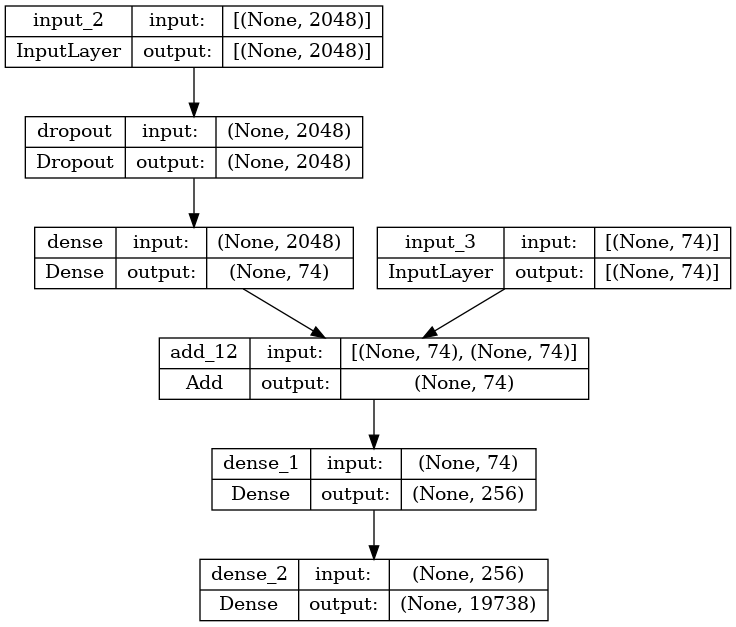

In [24]:
baseline_model = define_baseline_model(vocab_size, max_length)
plot_model(baseline_model, show_shapes=True)

In [25]:
generator = data_generator(captions_dict, features, tokenizer, max_length)
baseline_model.fit(generator, epochs=20, steps_per_epoch = 2500, verbose=1)

Epoch 1/20
2500/2500 [==============================] - 8s 3ms/step - loss: 9.9574
Epoch 2/20
2500/2500 [==============================] - 7s 3ms/step - loss: 6.4130
Epoch 3/20
2500/2500 [==============================] - 7s 3ms/step - loss: 6.2490
Epoch 4/20
2500/2500 [==============================] - 7s 3ms/step - loss: 6.1971
Epoch 5/20
2500/2500 [==============================] - 7s 3ms/step - loss: 6.1697
Epoch 6/20
2500/2500 [==============================] - 7s 3ms/step - loss: 6.0654
Epoch 7/20
2500/2500 [==============================] - 7s 3ms/step - loss: 6.0222
Epoch 8/20
2500/2500 [==============================] - 7s 3ms/step - loss: 6.0163
Epoch 9/20
2500/2500 [==============================] - 7s 3ms/step - loss: 5.9305
Epoch 10/20
2500/2500 [==============================] - 7s 3ms/step - loss: 5.8813
Epoch 11/20
2500/2500 [==============================] - 8s 3ms/step - loss: 5.9457
Epoch 12/20
2500/2500 [==============================] - 8s 3ms/step - loss: 6.1128
E

In [26]:
baseline_model.save("baseline_model.h5")

## Model

In [27]:
def define_model(vocab_size, max_length):
    
    inputs1 = Input(shape=(2048, ))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
   
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [28]:
print('Dataset: ', len(features))
print('Descriptions: train=', len(train_dict))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

Dataset:  31783
Descriptions: train= 30783
Vocabulary Size: 19738
Description Length:  74


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 74, 256)      5052928     ['input_5[0][0]']                
                                                                                                  
 dropout_1 (Dropout)            (None, 2048)         0           ['input_4[0][0]']                
                                                                                            

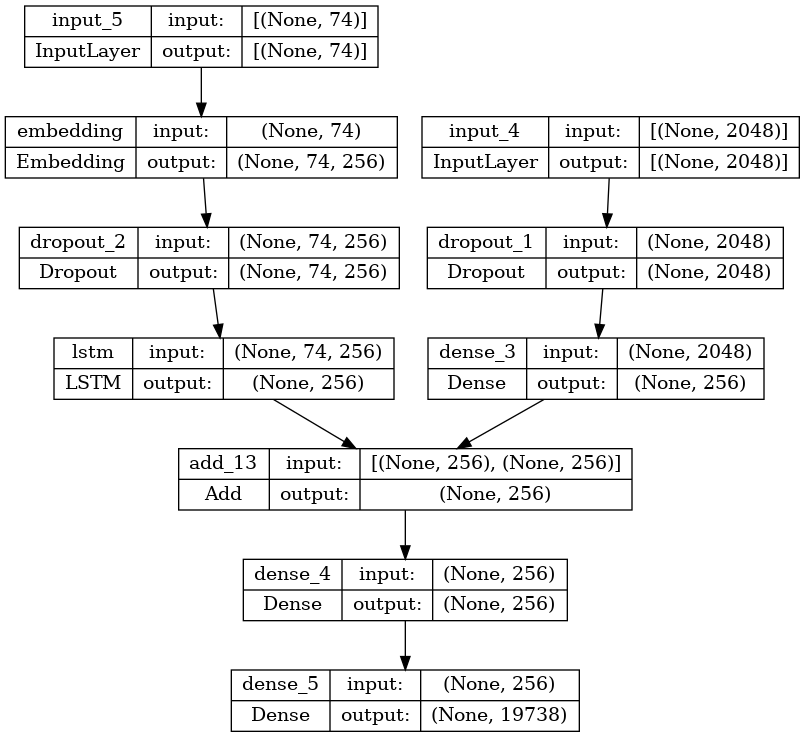

In [29]:
model = define_model(vocab_size, max_length)
plot_model(model, show_shapes=True)

In [30]:
generator = data_generator(captions_dict, features, tokenizer, max_length)
model.fit(generator, epochs=20, steps_per_epoch = 2500, verbose=1)

Epoch 1/20
2500/2500 [==============================] - 231s 91ms/step - loss: 5.3962
Epoch 2/20
2500/2500 [==============================] - 223s 89ms/step - loss: 4.7091
Epoch 3/20
2500/2500 [==============================] - 219s 88ms/step - loss: 4.4662
Epoch 4/20
2500/2500 [==============================] - 220s 88ms/step - loss: 4.3602
Epoch 5/20
2500/2500 [==============================] - 222s 89ms/step - loss: 4.3275
Epoch 6/20
2500/2500 [==============================] - 221s 88ms/step - loss: 4.1838
Epoch 7/20
2500/2500 [==============================] - 219s 88ms/step - loss: 4.2377
Epoch 8/20
2500/2500 [==============================] - 223s 89ms/step - loss: 4.3164
Epoch 9/20
2500/2500 [==============================] - 221s 89ms/step - loss: 4.2316
Epoch 10/20
2500/2500 [==============================] - 221s 88ms/step - loss: 4.1501
Epoch 11/20
2500/2500 [==============================] - 220s 88ms/step - loss: 4.2996
Epoch 12/20
2500/2500 [=============================

In [31]:
model.save("Image_captioning_30k.h5")

### Model 2

In [32]:
def define_model_2(vocab_size, max_length):
    
    inputs1 = Input(shape=(2048, ))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(512, activation='relu')(fe1)
    fe3 = Dropout(0.5)(fe2)
    fe4 = Dense(256, activation='relu')(fe3)
   
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe4, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [33]:
print('Dataset: ', len(features))
print('Descriptions: train=', len(train_dict))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)

Dataset:  31783
Descriptions: train= 30783
Vocabulary Size: 19738
Description Length:  74


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 dropout_3 (Dropout)            (None, 2048)         0           ['input_6[0][0]']                
                                                                                                  
 input_7 (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 512)          1049088     ['dropout_3[0][0]']              
                                                                                            

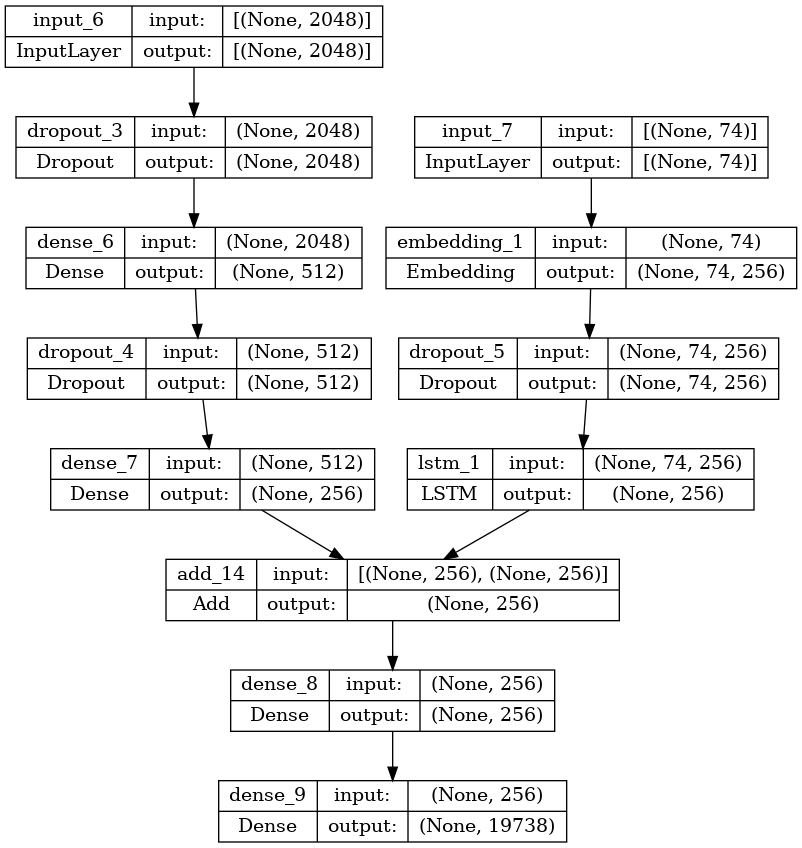

In [34]:
model_2 = define_model_2(vocab_size, max_length)
plot_model(model_2, show_shapes=True)

In [35]:
generator = data_generator(captions_dict, features, tokenizer, max_length)
model_2.fit(generator, epochs=20, steps_per_epoch = 2500, verbose=1)

Epoch 1/20
2500/2500 [==============================] - 230s 91ms/step - loss: 5.4162
Epoch 2/20
2500/2500 [==============================] - 222s 89ms/step - loss: 4.7587
Epoch 3/20
2500/2500 [==============================] - 222s 89ms/step - loss: 4.5243
Epoch 4/20
2500/2500 [==============================] - 222s 89ms/step - loss: 4.4176
Epoch 5/20
2500/2500 [==============================] - 224s 89ms/step - loss: 4.3846
Epoch 6/20
2500/2500 [==============================] - 224s 90ms/step - loss: 4.2494
Epoch 7/20
2500/2500 [==============================] - 222s 89ms/step - loss: 4.2905
Epoch 8/20
2500/2500 [==============================] - 221s 88ms/step - loss: 4.3641
Epoch 9/20
2500/2500 [==============================] - 224s 89ms/step - loss: 4.2653
Epoch 10/20
2500/2500 [==============================] - 223s 89ms/step - loss: 4.1810
Epoch 11/20
2500/2500 [==============================] - 222s 89ms/step - loss: 4.3391
Epoch 12/20
2500/2500 [=============================

In [36]:
model_2.save("Image_captioning_30k_2.h5")

### Another model

In [47]:
def define_model_3(vocab_size, max_length):
    
    inputs1 = Input(shape=(2048, ))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(1024, activation='relu')(fe1)
    fe3 = Dropout(0.5)(fe2)
    fe4 = Dense(512, activation='relu')(fe3)
    fe5 = Dropout(0.5)(fe4)
    fe6 = Dense(256, activation='relu')(fe5)
   
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    decoder1 = add([fe6, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_22 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 dropout_10 (Dropout)           (None, 2048)         0           ['input_22[0][0]']               
                                                                                                  
 dense_13 (Dense)               (None, 1024)         2098176     ['dropout_10[0][0]']             
                                                                                                  
 dropout_11 (Dropout)           (None, 1024)         0           ['dense_13[0][0]']               
                                                                                            

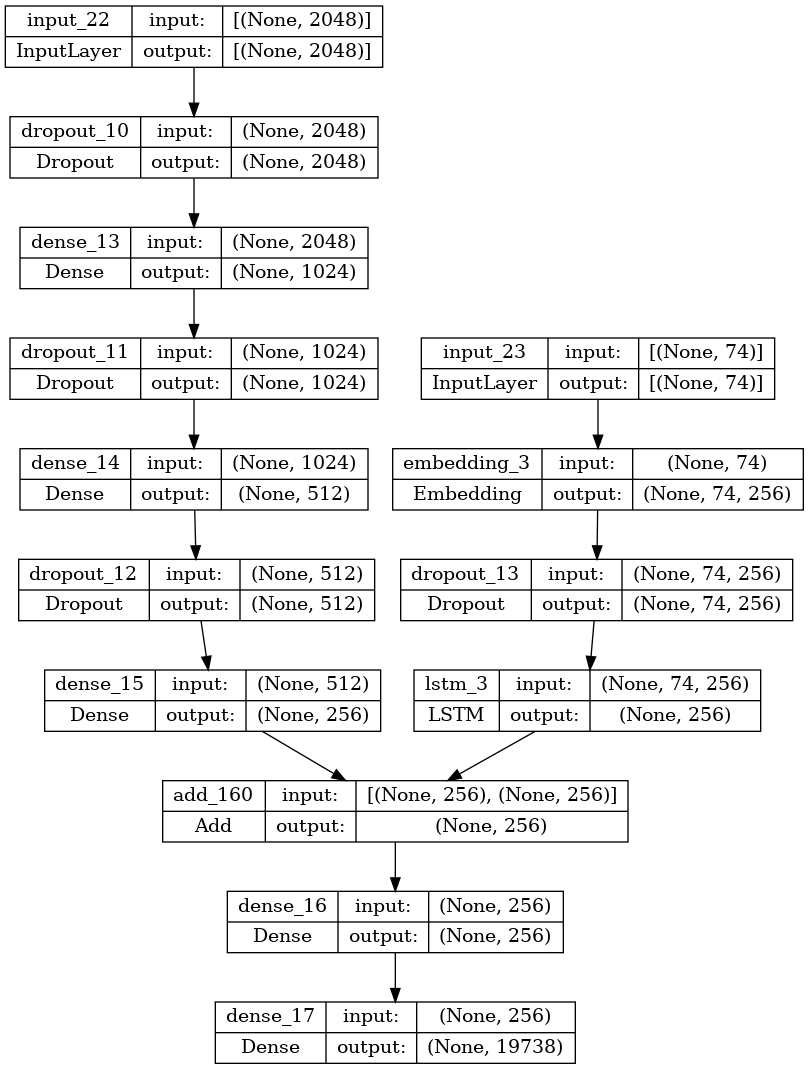

In [48]:
model_3 = define_model_3(vocab_size, max_length)
plot_model(model_3, show_shapes=True)

In [50]:
generator = data_generator(captions_dict, features, tokenizer, max_length)
model_3.fit(generator, epochs=20, steps_per_epoch = 2500, verbose=1)

Epoch 1/20
2500/2500 [==============================] - 224s 90ms/step - loss: 3.9666
Epoch 2/20
2500/2500 [==============================] - 226s 90ms/step - loss: 3.9203
Epoch 3/20
2500/2500 [==============================] - 226s 91ms/step - loss: 3.8480
Epoch 4/20
2500/2500 [==============================] - 227s 91ms/step - loss: 3.8377
Epoch 5/20
2500/2500 [==============================] - 223s 89ms/step - loss: 3.8828
Epoch 6/20
2500/2500 [==============================] - 227s 91ms/step - loss: 3.8226
Epoch 7/20
2500/2500 [==============================] - 225s 90ms/step - loss: 3.9057
Epoch 8/20
2500/2500 [==============================] - 223s 89ms/step - loss: 4.1115
Epoch 9/20
2500/2500 [==============================] - 224s 90ms/step - loss: 4.0794
Epoch 10/20
2500/2500 [==============================] - 226s 91ms/step - loss: 4.0234
Epoch 11/20
2500/2500 [==============================] - 225s 90ms/step - loss: 4.1906
Epoch 12/20
2500/2500 [=============================

In [51]:
model_3.save("Image_captioning_30k_3.h5")

### Testing the models

In [37]:
def one_img_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
    image = load_img(filename, target_size=(300, 300))
    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    feature = model.predict(image, verbose = 0)
    return feature

In [38]:
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word

def generate_desc(model, tokenizer, img, max_length):
    max_length = 74
    xception_model = Xception( include_top=False, pooling='avg' )
    photo = one_img_features(img, xception_model)
    text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        text += ' ' + word
        if word == 'endseq':
            break
    return ' '.join(text.split(' ')[1:-1])

In [39]:
def get_bleu_score(caption, prediction):
    items = []
    for item in caption:
        items.append(item.split())
    score = sentence_bleu(items, prediction.split(), weights=(0.5,0.5, 0, 0))
    return score

In [40]:
def get_meteor_score(caption, prediction):
    items = []
    for item in caption:
        items.append(item.split())
    score = meteor_score(items, prediction.split())
    return score

In [41]:
test = test_dict
temp = {}
for key, value in test.items():
    temp_list = []
    for item in value:
        temp_list.append(item[9:-7])
    temp[key] = temp_list
    
test_dict = temp

In [42]:
model = load_model('Image_captioning_30k.h5')
with open('tokenizer.p', 'rb') as f:
    tokenizer = pickle.load(f)

man in blue shirt is standing in front of the building


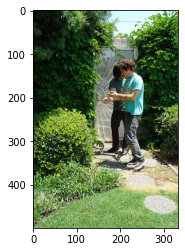

In [52]:

img = 'flickr30k/images/1000092795.jpg'


description = generate_desc(model, tokenizer, img, max_length)
img = Image.open(img)
print(description)
plt.imshow(img)

In [63]:
scores = {}
scores['model_1_bleu'] = []
scores['model_1_meteor'] = []
scores['model_2_bleu'] = []
scores['model_2_meteor'] = []
scores['model_3_bleu'] = []
scores['model_3_meteor'] = []
scores['model_4_bleu'] = []
scores['model_4_meteor'] = []

for key in tqdm(test_dict.keys()):
    img = 'flickr30k/images/' + key + '.jpg'
    prediction_1 = generate_desc(baseline_model, tokenizer, img, max_length)
    prediction_2 = generate_desc(model, tokenizer, img, max_length)
    prediction_3 = generate_desc(model_2, tokenizer, img, max_length)
    prediction_4 = generate_desc(model_3, tokenizer, img, max_length)
    
    scores['model_1_bleu'].append(get_bleu_score(test_dict[key], prediction_1))
    scores['model_1_meteor'].append(get_meteor_score(test_dict[key], prediction_1))
    
    scores['model_2_bleu'].append(get_bleu_score(test_dict[key], prediction_2))
    scores['model_2_meteor'].append(get_meteor_score(test_dict[key], prediction_2))
    
    scores['model_3_bleu'].append(get_bleu_score(test_dict[key], prediction_3))
    scores['model_3_meteor'].append(get_meteor_score(test_dict[key], prediction_3))
    
    scores['model_4_bleu'].append(get_bleu_score(test_dict[key], prediction_4))
    scores['model_4_meteor'].append(get_meteor_score(test_dict[key], prediction_4))

100%|██████████| 1000/1000 [2:05:05<00:00,  7.51s/it] 


In [67]:
scores_df = pd.DataFrame.from_dict(scores)

In [69]:
scores_df.mean()

model_1_bleu      0.041823
model_1_meteor    0.080763
model_2_bleu      0.191659
model_2_meteor    0.228408
model_3_bleu      0.179419
model_3_meteor    0.209244
model_4_bleu      0.153622
model_4_meteor    0.201868
dtype: float64

Baseline model:  man in in in in in in in in in
Sentence Bleu:  0.18257418583505533
Meteor Score:  0.2054794520547945
Model 1 Prediction:  man in blue shirt is standing in front of the building
Sentence Bleu:  0.504524979109513
Meteor Score:  0.7957957957957957
Model 2 Prediciton:  man in blue shirt is sitting on the ground
Sentence Bleu:  0.45643546458763845
Meteor Score:  0.4383680555555556
Model 3 Prediction:  man in blue shirt is standing in front of building
Sentence Bleu:  0.5163977794943222
Meteor Score:  0.806697108066971
['two young guys with shaggy hair look at their hands while hanging out in the yard', 'two young white males are outside near many bushes', 'two men in green shirts are standing in yard', 'man in blue shirt standing in garden', 'two friends enjoy time spent together']


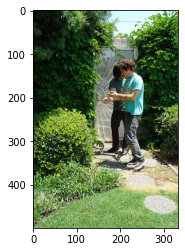


-------------------------------------------

Baseline model:  man in in in in in in in
Sentence Bleu:  5.273843307431707e-155
Meteor Score:  0.05102040816326531
Model 1 Prediction:  man in blue shirt is standing in front of building
Sentence Bleu:  6.6709427497276e-155
Meteor Score:  0.15
Model 2 Prediciton:  man in blue shirt is standing in front of an audience
Sentence Bleu:  6.360494346864465e-155
Meteor Score:  0.14851485148514848
Model 3 Prediction:  man in blue shirt is standing in front of building
Sentence Bleu:  6.6709427497276e-155
Meteor Score:  0.15
['several men in hard hats are operating giant pulley system', 'workers look down from up above on piece of equipment', 'two men working on machine wearing hard hats', 'four men on top of tall structure', 'three men on large rig']


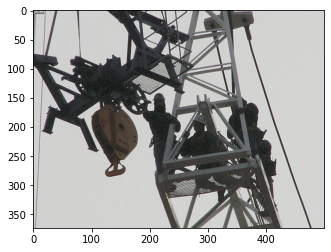


-------------------------------------------

Baseline model:  man in in in in in in in
Sentence Bleu:  7.458340731200295e-155
Meteor Score:  0.07462686567164178
Model 1 Prediction:  man in blue shirt is standing in front of the wall
Sentence Bleu:  1.0056824590358316e-154
Meteor Score:  0.145985401459854
Model 2 Prediciton:  man in blue shirt is sitting on the ground
Sentence Bleu:  8.612150057732663e-155
Meteor Score:  0.07407407407407407
Model 3 Prediction:  man in blue shirt is standing in front of building
Sentence Bleu:  1.0547686614863434e-154
Meteor Score:  0.14705882352941174
['child in pink dress is climbing up set of stairs in an entry way', 'little girl in pink dress going into wooden cabin', 'little girl climbing the stairs to her playhouse', 'little girl climbing into wooden playhouse', 'girl going into wooden building']


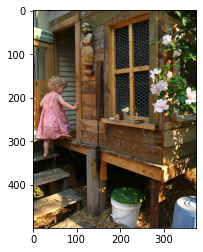


-------------------------------------------

Baseline model:  man in in in in in in in in in
Sentence Bleu:  0.14907119849998599
Meteor Score:  0.10000000000000002
Model 1 Prediction:  man in blue shirt is standing on the street
Sentence Bleu:  0.816496580927726
Meteor Score:  0.7060399917542773
Model 2 Prediciton:  man in blue shirt is standing in front of an audience
Sentence Bleu:  0.5640760748177662
Meteor Score:  0.5569306930693068
Model 3 Prediction:  man in blue shirt is standing in front of building
Sentence Bleu:  0.6666666666666667
Meteor Score:  0.5625
['someone in blue shirt and hat is standing on stair and leaning against window', 'man in blue shirt is standing on ladder cleaning window', 'man on ladder cleans the window of tall building', 'man in blue shirt and jeans on ladder cleaning windows', 'man on ladder cleans window']


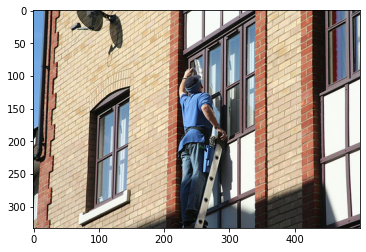


-------------------------------------------

Baseline model:  man in in in in in in in in in
Sentence Bleu:  6.6709427497276e-155
Meteor Score:  0.07874015748031496
Model 1 Prediction:  man in blue shirt is sitting on the floor
Sentence Bleu:  9.94445430826712e-155
Meteor Score:  0.1234567901234568
Model 2 Prediciton:  man in black shirt is sitting on the floor
Sentence Bleu:  0.372677996249965
Meteor Score:  0.2336860670194004
Model 3 Prediction:  man in black shirt is standing in front of an old fashioned truck
Sentence Bleu:  0.25318484177091666
Meteor Score:  0.28615384615384615
['two men one in gray shirt one in black shirt standing near stove', 'two guy cooking and joking around with the camera', 'two men in kitchen cooking food on stove', 'two men are at the stove preparing food', 'two men are cooking meal']


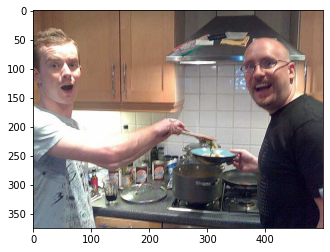


-------------------------------------------

Baseline model:  man in in in in in in in
Sentence Bleu:  0.18898223650461357
Meteor Score:  0.08620689655172413
Model 1 Prediction:  man in black shirt is sitting on the ground
Sentence Bleu:  0.26352313834736496
Meteor Score:  0.20833333333333331
Model 2 Prediciton:  man in black shirt is sitting on the floor
Sentence Bleu:  0.26352313834736496
Meteor Score:  0.20833333333333331
Model 3 Prediction:  man in black shirt is standing in front of an old fashioned truck
Sentence Bleu:  0.16012815380508713
Meteor Score:  0.13157894736842107
['two people in the photo are playing the guitar and the other is poking at him', 'man in green holds guitar while the other man observes his shirt', 'man is fixing the guitar players costume', 'guy stitching up another man coat', 'the two boys playing guitar']


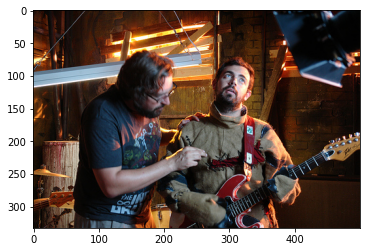


-------------------------------------------

Baseline model:  man in in in in in in in in in
Sentence Bleu:  6.6709427497276e-155
Meteor Score:  0.09174311926605505
Model 1 Prediction:  man in blue shirt is standing in front of the wall
Sentence Bleu:  1.0056824590358316e-154
Meteor Score:  0.15384615384615385
Model 2 Prediciton:  man in blue shirt is sitting on the ground
Sentence Bleu:  0.408248290463863
Meteor Score:  0.41666666666666663
Model 3 Prediction:  man in blue shirt is standing in front of building
Sentence Bleu:  9.434137710479516e-155
Meteor Score:  0.15625
['man sits in chair while holding large stuffed animal of lion', 'man is sitting on chair holding large stuffed animal', 'man completes the finishing touches on stuffed lion', 'man holds large stuffed lion toy', 'man is smiling at stuffed lion']


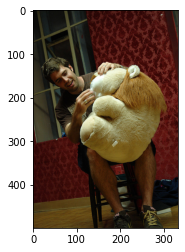


-------------------------------------------

Baseline model:  man in in in in in in in in in
Sentence Bleu:  4.717068855239749e-155
Meteor Score:  0.0423728813559322
Model 1 Prediction:  man in blue shirt is standing in front of the building
Sentence Bleu:  0.19069251784911848
Meteor Score:  0.21475256769374415
Model 2 Prediciton:  man in blue shirt is standing in the snow
Sentence Bleu:  0.23570226039551587
Meteor Score:  0.21842355175688513
Model 3 Prediction:  man in blue shirt is standing in front of building
Sentence Bleu:  0.18257418583505533
Meteor Score:  0.21657250470809788
['girl is on rollerskates talking on her cellphone standing in parking lot', 'trendy girl talking on her cellphone while gliding slowly down the street', 'young adult wearing rollerblades holding cellular phone to her ear', 'there is young girl on her cellphone while skating', 'woman talking on cellphone and wearing rollerskates']


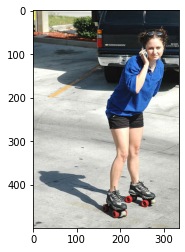


-------------------------------------------

Baseline model:  man in in in in in in in
Sentence Bleu:  7.458340731200295e-155
Meteor Score:  0.043103448275862065
Model 1 Prediction:  man in blue shirt is standing in front of the wall
Sentence Bleu:  8.995097368733392e-155
Meteor Score:  0.0892857142857143
Model 2 Prediciton:  man in blue shirt is sitting on the ground
Sentence Bleu:  8.612150057732663e-155
Meteor Score:  0.0617283950617284
Model 3 Prediction:  man in black shirt is standing in front of an old fashioned truck
Sentence Bleu:  1.0133889507316166e-154
Meteor Score:  0.15384615384615385
['an asian man wearing black suit stands near darkhaired woman and brownhaired woman', 'three people are standing outside near large pipes and metal railing', 'young woman walks past two young people dressed in hip black outfits', 'woman with large purse is walking by gate', 'several people standing outside building']


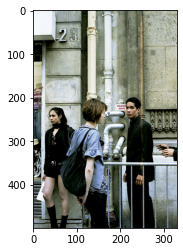


-------------------------------------------

Baseline model:  man in in in in in in in in in
Sentence Bleu:  4.717068855239749e-155
Meteor Score:  0.05000000000000001
Model 1 Prediction:  man in blue shirt is standing in front of building
Sentence Bleu:  6.6709427497276e-155
Meteor Score:  0.10000000000000002
Model 2 Prediciton:  man in blue shirt is standing in the snow
Sentence Bleu:  0.16666666666666669
Meteor Score:  0.11904761904761907
Model 3 Prediction:  man in blue shirt is standing on the ground
Sentence Bleu:  8.612150057732663e-155
Meteor Score:  0.15151515151515152
['two men in germany jumping over rail at the same time without shirts', 'two youths are jumping over roadside railing at night', 'boys dancing on poles in the middle of the night', 'two men with no shirts jumping over rail', 'two guys jumping over gate together']


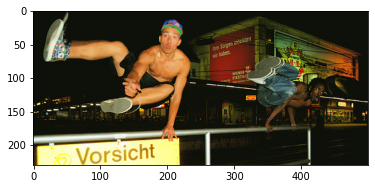


-------------------------------------------

Baseline model:  man in in in in in in in in in
Sentence Bleu:  4.717068855239749e-155
Meteor Score:  0.06097560975609756
Model 1 Prediction:  man in blue shirt is standing in front of the water
Sentence Bleu:  6.360494346864465e-155
Meteor Score:  0.12048192771084339
Model 2 Prediciton:  man in blue shirt is standing in front of an audience
Sentence Bleu:  6.360494346864465e-155
Meteor Score:  0.12048192771084339
Model 3 Prediction:  man in blue shirt is standing in front of building
Sentence Bleu:  6.6709427497276e-155
Meteor Score:  0.12195121951219512
['five ballet dancers caught mid jump in dancing studio with sunlight coming through window', 'ballet dancers in studio practice jumping with wonderful form', 'five girls are leaping simultaneously in dance practice room', 'five girls dancing and bending feet in ballet class', 'ballet class of five girls jumping in sequence']


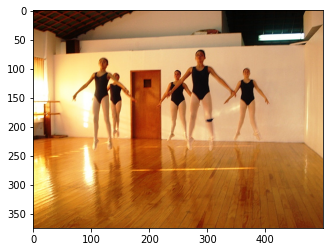


-------------------------------------------

Baseline model:  man in in in in in in in in in in
Sentence Bleu:  4.497548684366688e-155
Meteor Score:  0.026178010471204192
Model 1 Prediction:  man in blue shirt is standing on the ground
Sentence Bleu:  5.630618124510453e-155
Meteor Score:  0.07936507936507937
Model 2 Prediciton:  man in blue shirt is standing in the snow
Sentence Bleu:  5.630618124510453e-155
Meteor Score:  0.07936507936507937
Model 3 Prediction:  man in blue shirt is standing in front of building
Sentence Bleu:  6.036118613529226e-155
Meteor Score:  0.11811023622047245
['three young men and young woman wearing sneakers are leaping in midair at the top of flight of concrete stairs', 'four casually dressed guys jumping down stairway outdoors with stone wall behind them', 'four guys three wearing hats one not are jumping at the top of staircase', 'four men with excited faces are jumping down from the top of stairs', 'four people are jumping from the top of flight of stai

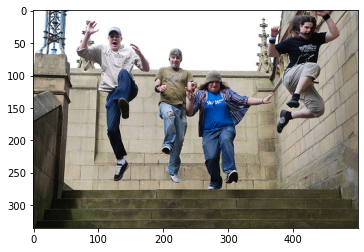


-------------------------------------------

Baseline model:  dog dog dog in in in in in
Sentence Bleu:  9.134564559628536e-155
Meteor Score:  0.14084507042253522
Model 1 Prediction:  two dogs are playing in the snow
Sentence Bleu:  0.5345224838248488
Meteor Score:  0.26785714285714285
Model 2 Prediciton:  two dogs are running through the snow
Sentence Bleu:  0.3086066999241838
Meteor Score:  0.3234880450070324
Model 3 Prediction:  two dogs are playing in the snow
Sentence Bleu:  0.5345224838248488
Meteor Score:  0.26785714285714285
['black dog and white dog with brown spots are staring at each other in the street', 'black dog and tricolored dog playing with each other on the road', 'two dogs of different breeds looking at each other on the road', 'two dogs on pavement moving toward each other', 'black dog and spotted dog are fighting']


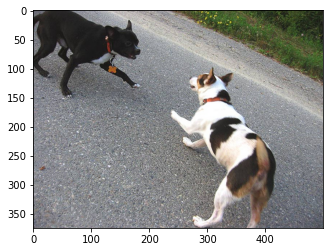


-------------------------------------------

Baseline model:  man in in in in in in in in in
Sentence Bleu:  0.14907119849998599
Meteor Score:  0.10989010989010987
Model 1 Prediction:  man in blue shirt is standing in front of building
Sentence Bleu:  0.18257418583505533
Meteor Score:  0.1648351648351648
Model 2 Prediciton:  man in blue shirt is standing in the street
Sentence Bleu:  0.372677996249965
Meteor Score:  0.23662551440329216
Model 3 Prediction:  man in blue shirt is standing in front of building
Sentence Bleu:  0.18257418583505533
Meteor Score:  0.1648351648351648
['man with reflective safety clothes and ear protection drives john deere tractor on road', 'john deere tractors cruises down street while the driver wears easy to see clothing', 'man in neon green and orange uniform is driving on green tractor', 'man in tractor wearing headphones driving down paved street', 'man driving john deere tractor on main road in the country']


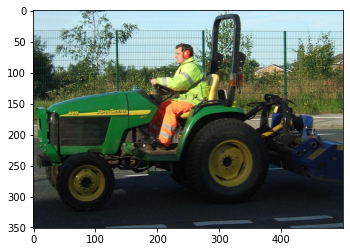


-------------------------------------------

Baseline model:  man in in in in in in in
Sentence Bleu:  4.654150383524979e-155
Meteor Score:  0.08064516129032259
Model 1 Prediction:  man in blue shirt is standing in front of the building
Sentence Bleu:  0.30158724076130894
Meteor Score:  0.43138586956521735
Model 2 Prediciton:  man in blue shirt is sitting on the ground
Sentence Bleu:  7.031791076575252e-155
Meteor Score:  0.07936507936507937
Model 3 Prediction:  man in black shirt is standing in front of an old fashioned truck
Sentence Bleu:  0.2773500981126146
Meteor Score:  0.42220744680851063
['some women are standing in front of bus with buildings behind it', 'several women stand on city street with tall buildings', 'group of women are standing in front of bus', 'several women wait outside in city', 'women are standing outside']


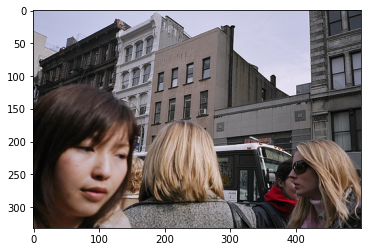


-------------------------------------------

Baseline model:  man in in in in in in in in in
Sentence Bleu:  4.717068855239749e-155
Meteor Score:  0.05000000000000001
Model 1 Prediction:  man in black shirt is sitting on the floor
Sentence Bleu:  0.2109156496639261
Meteor Score:  0.2504960317460318
Model 2 Prediciton:  man in black shirt is sitting on the floor
Sentence Bleu:  0.2109156496639261
Meteor Score:  0.2504960317460318
Model 3 Prediction:  man in black shirt is standing in front of an old fashioned truck
Sentence Bleu:  0.16012815380508713
Meteor Score:  0.11538461538461539
['young woman with dark hair and wearing glasses is putting white powder on cake using sifter', 'lady in black top with glasses is sprinkling powdered sugar on bundt cake', 'woman wearing glasses sprinkles powdered sugar onto her bundt cake', 'girl in black jacket sifting powdered sugar over chocolate cake', 'standing woman holds pan over cake']


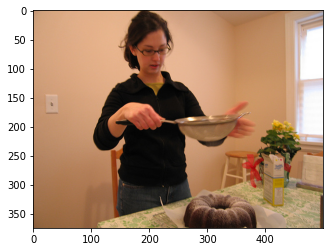


-------------------------------------------

Baseline model:  man in in in in in in in in in
Sentence Bleu:  8.170202920075766e-155
Meteor Score:  0.0974025974025974
Model 1 Prediction:  man in blue shirt is standing in front of the building
Sentence Bleu:  0.33028912953790823
Meteor Score:  0.37128712871287134
Model 2 Prediciton:  man in blue shirt is standing in the snow
Sentence Bleu:  0.23570226039551587
Meteor Score:  0.20833333333333331
Model 3 Prediction:  man in blue shirt is standing on the beach
Sentence Bleu:  9.94445430826712e-155
Meteor Score:  0.1111111111111111
['small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it', 'little girl covered in paint sits in front of painted rainbow with her hands in bowl', 'there is girl with pigtails sitting in front of rainbow painting', 'little girl is sitting in front of large painted rainbow', 'young girl with pigtails painting outside in the grass']


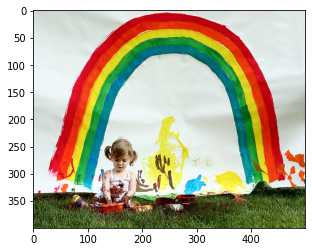


-------------------------------------------

Baseline model:  man in in in in in in in in in
Sentence Bleu:  4.717068855239749e-155
Meteor Score:  0.05494505494505494
Model 1 Prediction:  man in blue shirt is standing on the ground
Sentence Bleu:  0.26352313834736496
Meteor Score:  0.26976495726495725
Model 2 Prediciton:  man in blue shirt is standing in the snow
Sentence Bleu:  8.612150057732663e-155
Meteor Score:  0.12820512820512822
Model 3 Prediction:  man in blue shirt is playing with the ball
Sentence Bleu:  9.94445430826712e-155
Meteor Score:  0.12820512820512822
['man sleeping on bench outside with white and black dog sitting next to him', 'man lays on the bench to which white dog is also tied', 'man laying on bench holding leash of dog sitting on ground', 'shirtless man lies on park bench with his dog', 'man lays on bench while his dog sits by him']


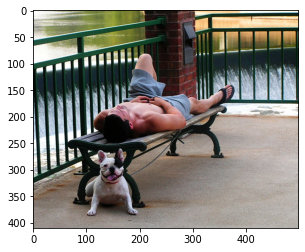


-------------------------------------------

Baseline model:  man in in in in in in in in
Sentence Bleu:  7.031791076575252e-155
Meteor Score:  0.07407407407407407
Model 1 Prediction:  man in black shirt is sitting on the floor
Sentence Bleu:  0.23570226039551587
Meteor Score:  0.16702977487291215
Model 2 Prediciton:  man in black shirt is sitting on the floor
Sentence Bleu:  0.23570226039551587
Meteor Score:  0.16702977487291215
Model 3 Prediction:  man in black shirt is standing in front of an old fashioned truck
Sentence Bleu:  6.635198182720221e-155
Meteor Score:  0.10791366906474818
['group of adults inside home sitting on chairs arranged in circle playing type of musical instruments', 'five musicians man and four women practicing sheet music using flutes in living room', 'people gathered in circle some holding musical instruments', 'people gathered in room to talk about their favorite tunes', 'five people are sitting in circle with instruments']


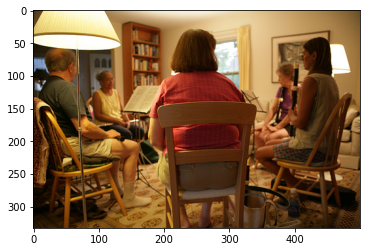


-------------------------------------------

Baseline model:  man in in in in in in in in
Sentence Bleu:  4.4493443496507244e-155
Meteor Score:  0.042735042735042736
Model 1 Prediction:  man in black shirt is playing guitar
Sentence Bleu:  0.17410441154600917
Meteor Score:  0.12417218543046359
Model 2 Prediciton:  man in black shirt is sitting on the floor
Sentence Bleu:  7.70649047396433e-155
Meteor Score:  0.07936507936507937
Model 3 Prediction:  man in black shirt is standing in front of an old man in black shirt
Sentence Bleu:  7.702941184607866e-155
Meteor Score:  0.11363636363636363
['two women both wearing glasses are playing clarinets and an elderly woman is playing stringed instrument', 'at least four instrumentalists play clarinets and other instruments in curtained room', 'four women in living room three of which are clearly playing musical instrument', 'bunch of elderly women play their clarinets together as they read off sheet music', 'group of four women are performing m

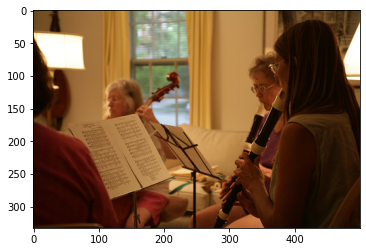


-------------------------------------------

Baseline model:  man in in in in in in in
Sentence Bleu:  0.23145502494313785
Meteor Score:  0.125
Model 1 Prediction:  man in blue shirt is standing on the beach
Sentence Bleu:  0.5
Meteor Score:  0.48888888888888893
Model 2 Prediciton:  man in blue shirt is standing in the snow
Sentence Bleu:  0.5
Meteor Score:  0.3444444444444445
Model 3 Prediction:  man in blue shirt is standing on the beach
Sentence Bleu:  0.5
Meteor Score:  0.48888888888888893
['person in gray stands alone on structure outdoors in the dark', 'large structure has broken and is laying in roadway', 'man in gray coat is standing on washed out bridge', 'man stands on wooden supports and surveys damage', 'man in jacket and jeans standing on bridge']


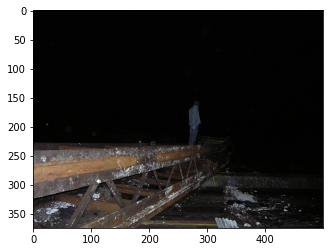


-------------------------------------------



In [77]:
i = 0
for key in test_dict.keys():
    img = 'flickr30k/images/' + key + '.jpg'
    prediction_1 = generate_desc(baseline_model, tokenizer, img, max_length)
    prediction_2 = generate_desc(model, tokenizer, img, max_length)
    prediction_3 = generate_desc(model_2, tokenizer, img, max_length)
    prediction_4 = generate_desc(model_3, tokenizer, img, max_length)
    print('Baseline model: ', prediction_1)
    print('Sentence Bleu: ', get_bleu_score(test_dict[key], prediction_1))
    print('Meteor Score: ', get_meteor_score(test_dict[key], prediction_1))
    
    print('Model 1 Prediction: ', prediction_2)
    print('Sentence Bleu: ', get_bleu_score(test_dict[key], prediction_2))
    print('Meteor Score: ', get_meteor_score(test_dict[key], prediction_2))
    
    print('Model 2 Prediciton: ', prediction_3)
    print('Sentence Bleu: ', get_bleu_score(test_dict[key], prediction_3))
    print('Meteor Score: ', get_meteor_score(test_dict[key], prediction_3))
    
    print('Model 3 Prediction: ', prediction_4)
    print('Sentence Bleu: ', get_bleu_score(test_dict[key], prediction_4))
    print('Meteor Score: ', get_meteor_score(test_dict[key], prediction_4))
    
    print(test_dict[key])
    img = Image.open(img)
    plt.imshow(img)
    plt.show()
    print('\n-------------------------------------------\n')
    
    if i == 20:
        break
    i = i + 1
    